Loaded 500 replications from raw results
Successfully processed 500 valid replications out of 500 total

UPDATED SIMULATION RESULTS SUMMARY (with respect to average true survival)
                    Metric              Initial         Kaplan-Meier             Targeted
            MSE (avg_true) 0.002917 (±0.003115) 0.002782 (±0.002613) 0.001544 (±0.001378)
  Absolute Bias (avg_true) 0.041329 (±0.022537) 0.040691 (±0.020397) 0.030631 (±0.014867)
    Variance (across reps) 0.002732 (±0.001350) 0.002765 (±0.001399) 0.001382 (±0.000577)
Model Coverage (avg. true)     0.7551 (±0.2375)     0.5584 (±0.2782)     0.9098 (±0.1668)
    CI Width (model-based)     0.1608 (±0.0578)     0.0755 (±0.0019)     0.4773 (±0.3942)


IMPROVEMENT PERCENTAGES (with respect to average true survival):
--------------------------------------------------------------------------------
Targeted vs Initial MSE: 47.06% improvement
Targeted vs KM MSE: 44.49% improvement
Targeted vs Initial Bias: 25.89% improvement
Targ

/var/folders/s9/cp67nwl1685gb_f0prtd64sm0000gn/T/ipykernel_21877/4192238223.py:323: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(mse_per_replication, labels=['Initial', 'Kaplan-Meier', 'Targeted'])
/var/folders/s9/cp67nwl1685gb_f0prtd64sm0000gn/T/ipykernel_21877/4192238223.py:337: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(abs_bias_per_replication, labels=['Initial', 'Kaplan-Meier', 'Targeted'])
/var/folders/s9/cp67nwl1685gb_f0prtd64sm0000gn/T/ipykernel_21877/4192238223.py:351: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(coverage_per_replication, labels=['Initial', 'Kaplan-Mei

Updated summary table saved to 'results/updated_summary_table.csv'
Detailed metrics saved to 'results/detailed_metrics.json'
New plots saved to 'results' directory


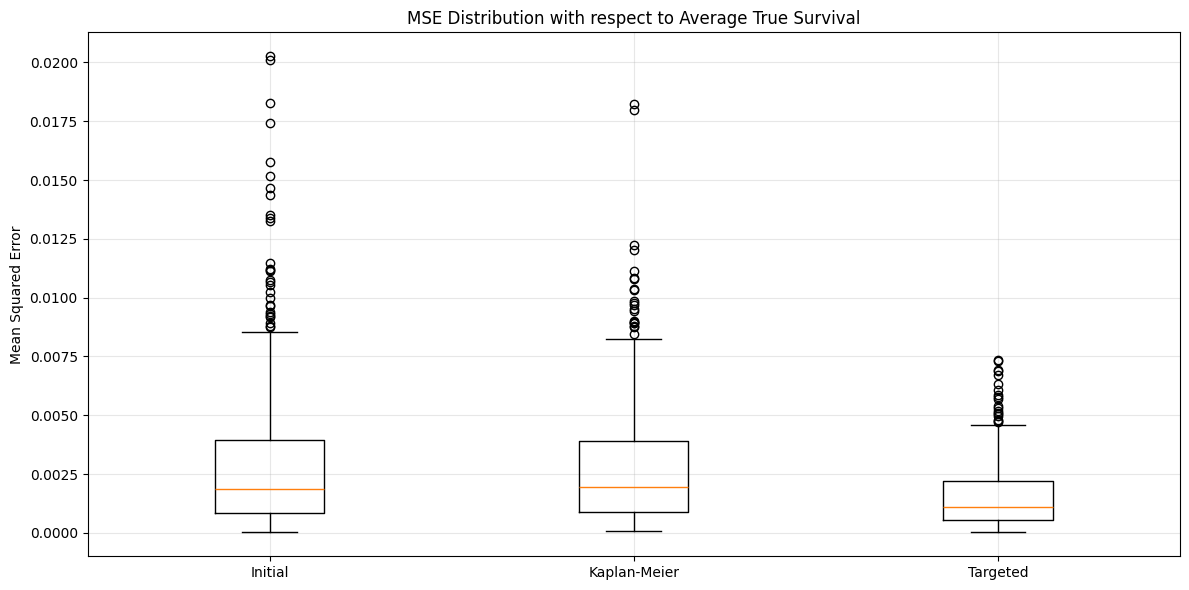

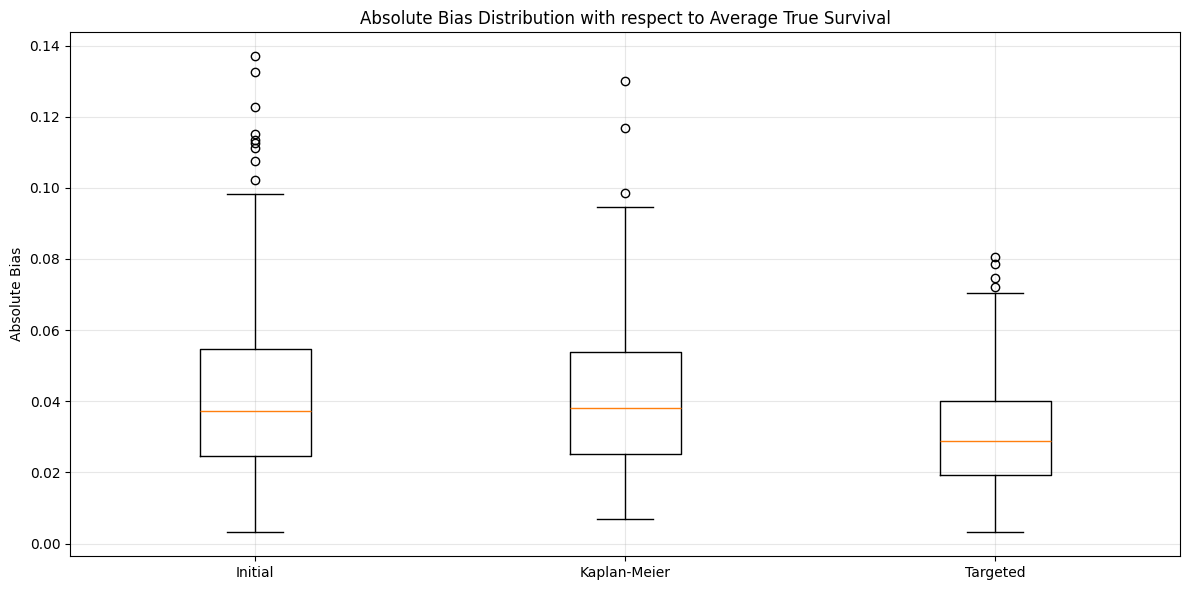

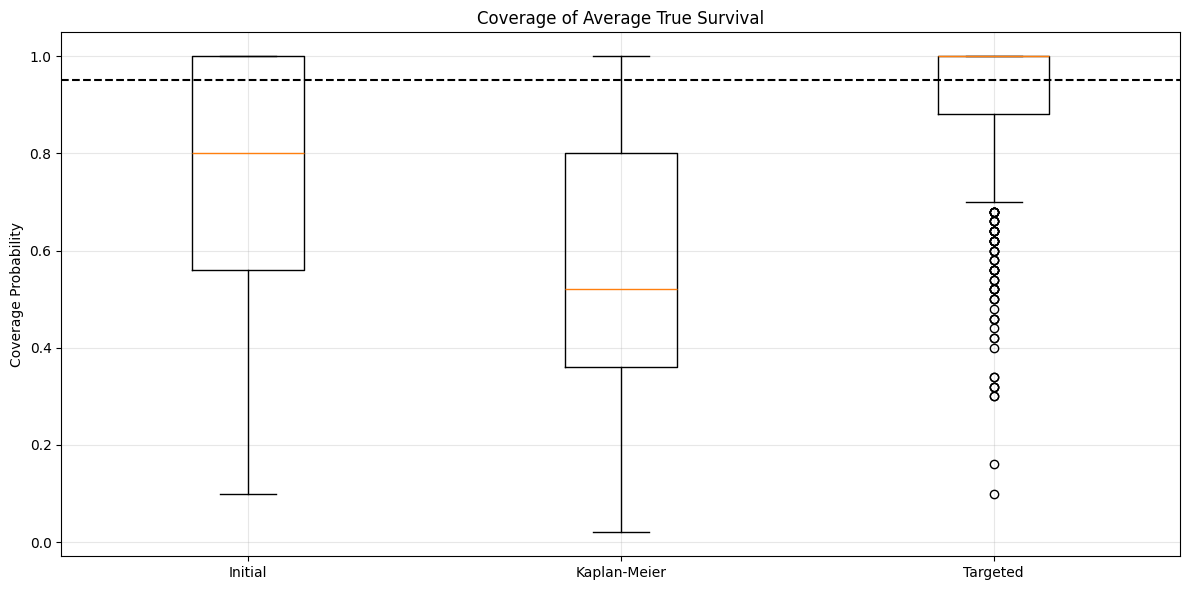

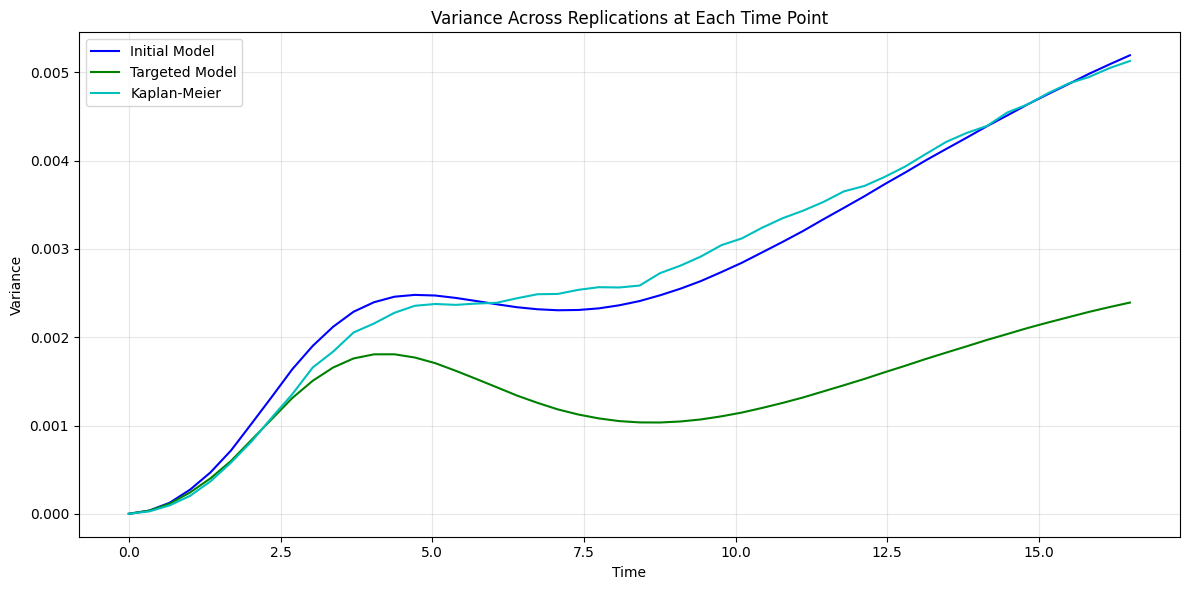

In [1]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import ast

# Path to results directory
results_dir = 'results'

# Helper function to safely convert string arrays to numpy arrays
def safe_convert_array(array_str):
    if not isinstance(array_str, str):
        return array_str
    
    try:
        # Try to use ast.literal_eval which is safer than eval
        return np.array(ast.literal_eval(array_str))
    except (SyntaxError, ValueError):
        # If that fails, try to parse as a space-separated list of numbers
        try:
            return np.array([float(x) for x in array_str.strip('[]').split()])
        except:
            # If all else fails, try to handle numpy array string formatting
            try:
                # Remove 'array(' prefix and ')' suffix if present
                cleaned = array_str.replace('array(', '').replace(')', '')
                # Remove redundant brackets if needed
                cleaned = cleaned.replace('[', '').replace(']', '')
                # Split by whitespace and convert to floats
                return np.array([float(x) for x in cleaned.split()])
            except:
                print(f"Could not parse array string: {array_str[:100]}...")
                return None

# Load the raw simulation results
try:
    df_results = pd.read_csv(f'{results_dir}/all_replications_metrics.csv')
    survival_curves = pd.read_csv(f'{results_dir}/average_survival_curves.csv')
    
    # Try to load aggregate metrics if they exist
    try:
        with open(f'{results_dir}/aggregate_metrics.json', 'r') as f:
            aggregate_metrics = json.load(f)
    except:
        aggregate_metrics = None
        
    print(f"Loaded {len(df_results)} replications from raw results")
except Exception as e:
    print(f"Error loading results: {e}")
    print("Make sure the results directory exists and contains the necessary files")
    exit(1)

# Extract time points and average true survival
time_points = survival_curves['time'].values
avg_true_survival = survival_curves['true_survival'].values
n_time_points = len(time_points)

# Get the number of replications
n_replications = len(df_results)

# Initialize arrays to store all survival curves across replications
all_initial_survival = np.zeros((n_replications, n_time_points))
all_targeted_survival = np.zeros((n_replications, n_time_points))
all_km_survival = np.zeros((n_replications, n_time_points))

# Arrays for confidence intervals
all_ci_init_lower = np.zeros((n_replications, n_time_points))
all_ci_init_upper = np.zeros((n_replications, n_time_points))
all_ci_proj_lower = np.zeros((n_replications, n_time_points))
all_ci_proj_upper = np.zeros((n_replications, n_time_points))
all_ci_km_lower = np.zeros((n_replications, n_time_points))
all_ci_km_upper = np.zeros((n_replications, n_time_points))

# Valid replication indexes
valid_replications = []

# First, collect all survival curves to compute variance across replications
for i, row in df_results.iterrows():
    rep_num = row['rep_number']
    
    # Extract survival curves for this replication - using our safe conversion function
    initial_survival = safe_convert_array(row['initial_survival'])
    targeted_survival = safe_convert_array(row['targeted_survival'])
    km_survival = safe_convert_array(row['km_survival'])
    
    # Confidence intervals
    ci_init_lower = safe_convert_array(row['ci_init_lower'])
    ci_init_upper = safe_convert_array(row['ci_init_upper'])
    ci_proj_lower = safe_convert_array(row['ci_proj_lower'])
    ci_proj_upper = safe_convert_array(row['ci_proj_upper'])
    ci_km_lower = safe_convert_array(row['ci_km_lower'])
    ci_km_upper = safe_convert_array(row['ci_km_upper'])
    
    # Skip this replication if any array conversion failed
    if any(x is None for x in [initial_survival, targeted_survival, km_survival, 
                              ci_init_lower, ci_init_upper, ci_proj_lower, 
                              ci_proj_upper, ci_km_lower, ci_km_upper]):
        print(f"Skipping replication {rep_num} due to parsing errors")
        continue
    
    # Make sure arrays have the same length as avg_true_survival
    if len(initial_survival) != len(avg_true_survival):
        print(f"Warning: Length mismatch for rep {rep_num} - initial_survival: {len(initial_survival)}, avg_true_survival: {len(avg_true_survival)}")
        # Truncate or pad to match required length
        if len(initial_survival) > n_time_points:
            initial_survival = initial_survival[:n_time_points]
            targeted_survival = targeted_survival[:n_time_points]
            km_survival = km_survival[:n_time_points]
            ci_init_lower = ci_init_lower[:n_time_points]
            ci_init_upper = ci_init_upper[:n_time_points]
            ci_proj_lower = ci_proj_lower[:n_time_points]
            ci_proj_upper = ci_proj_upper[:n_time_points]
            ci_km_lower = ci_km_lower[:n_time_points]
            ci_km_upper = ci_km_upper[:n_time_points]
        else:
            # Pad with NaN or last value if too short
            pad_length = n_time_points - len(initial_survival)
            initial_survival = np.pad(initial_survival, (0, pad_length), 'constant', constant_values=np.nan)
            targeted_survival = np.pad(targeted_survival, (0, pad_length), 'constant', constant_values=np.nan)
            km_survival = np.pad(km_survival, (0, pad_length), 'constant', constant_values=np.nan)
            ci_init_lower = np.pad(ci_init_lower, (0, pad_length), 'constant', constant_values=np.nan)
            ci_init_upper = np.pad(ci_init_upper, (0, pad_length), 'constant', constant_values=np.nan)
            ci_proj_lower = np.pad(ci_proj_lower, (0, pad_length), 'constant', constant_values=np.nan)
            ci_proj_upper = np.pad(ci_proj_upper, (0, pad_length), 'constant', constant_values=np.nan)
            ci_km_lower = np.pad(ci_km_lower, (0, pad_length), 'constant', constant_values=np.nan)
            ci_km_upper = np.pad(ci_km_upper, (0, pad_length), 'constant', constant_values=np.nan)
    
    # Store survival curves from this replication
    all_initial_survival[i] = initial_survival
    all_targeted_survival[i] = targeted_survival
    all_km_survival[i] = km_survival
    
    # Store confidence intervals
    all_ci_init_lower[i] = ci_init_lower
    all_ci_init_upper[i] = ci_init_upper
    all_ci_proj_lower[i] = ci_proj_lower
    all_ci_proj_upper[i] = ci_proj_upper
    all_ci_km_lower[i] = ci_km_lower
    all_ci_km_upper[i] = ci_km_upper
    
    valid_replications.append(i)

# Ensure we only use valid replications
all_initial_survival = all_initial_survival[valid_replications]
all_targeted_survival = all_targeted_survival[valid_replications]
all_km_survival = all_km_survival[valid_replications]
all_ci_init_lower = all_ci_init_lower[valid_replications]
all_ci_init_upper = all_ci_init_upper[valid_replications]
all_ci_proj_lower = all_ci_proj_lower[valid_replications]
all_ci_proj_upper = all_ci_proj_upper[valid_replications]
all_ci_km_lower = all_ci_km_lower[valid_replications]
all_ci_km_upper = all_ci_km_upper[valid_replications]

print(f"Successfully processed {len(valid_replications)} valid replications out of {n_replications} total")

# Calculate metrics with respect to the average true survival
# 1. MSE
initial_mse = np.mean((all_initial_survival - avg_true_survival)**2)
targeted_mse = np.mean((all_targeted_survival - avg_true_survival)**2)
km_mse = np.mean((all_km_survival - avg_true_survival)**2)

# 2. Absolute Bias as average of absolute differences
initial_abs_bias = np.mean(np.abs(all_initial_survival - avg_true_survival))
targeted_abs_bias = np.mean(np.abs(all_targeted_survival - avg_true_survival))
km_abs_bias = np.mean(np.abs(all_km_survival - avg_true_survival))

# 3. Variance across replications at each time point, then averaged
# For each time point, compute the variance across replications
initial_variance_per_time = np.var(all_initial_survival, axis=0)
targeted_variance_per_time = np.var(all_targeted_survival, axis=0)
km_variance_per_time = np.var(all_km_survival, axis=0)

# Average these variances across time points
initial_avg_variance = np.mean(initial_variance_per_time)
targeted_avg_variance = np.mean(targeted_variance_per_time)
km_avg_variance = np.mean(km_variance_per_time)

# Calculate coverage of average true survival
# For each replication and time point, check if CI covers avg_true_survival
initial_covers = (all_ci_init_lower <= avg_true_survival) & (avg_true_survival <= all_ci_init_upper)
targeted_covers = (all_ci_proj_lower <= avg_true_survival) & (avg_true_survival <= all_ci_proj_upper)
km_covers = (all_ci_km_lower <= avg_true_survival) & (avg_true_survival <= all_ci_km_upper)

# Average across time points for each replication
initial_covers_avg = np.mean(initial_covers, axis=1)
targeted_covers_avg = np.mean(targeted_covers, axis=1)
km_covers_avg = np.mean(km_covers, axis=1)

# Calculate CI widths
initial_ci_width = np.mean(all_ci_init_upper - all_ci_init_lower)
targeted_ci_width = np.mean(all_ci_proj_upper - all_ci_proj_lower)
km_ci_width = np.mean(all_ci_km_upper - all_ci_km_lower)

# Standard deviations of metrics across replications
initial_mse_sd = np.std(np.mean((all_initial_survival - avg_true_survival)**2, axis=1))
targeted_mse_sd = np.std(np.mean((all_targeted_survival - avg_true_survival)**2, axis=1))
km_mse_sd = np.std(np.mean((all_km_survival - avg_true_survival)**2, axis=1))

initial_abs_bias_sd = np.std(np.mean(np.abs(all_initial_survival - avg_true_survival), axis=1))
targeted_abs_bias_sd = np.std(np.mean(np.abs(all_targeted_survival - avg_true_survival), axis=1))
km_abs_bias_sd = np.std(np.mean(np.abs(all_km_survival - avg_true_survival), axis=1))

initial_avg_variance_sd = np.std(initial_variance_per_time)
targeted_avg_variance_sd = np.std(targeted_variance_per_time)
km_avg_variance_sd = np.std(km_variance_per_time)

initial_covers_avg_sd = np.std(initial_covers_avg)
targeted_covers_avg_sd = np.std(targeted_covers_avg)
km_covers_avg_sd = np.std(km_covers_avg)

initial_ci_width_sd = np.std(np.mean(all_ci_init_upper - all_ci_init_lower, axis=1))
targeted_ci_width_sd = np.std(np.mean(all_ci_proj_upper - all_ci_proj_lower, axis=1))
km_ci_width_sd = np.std(np.mean(all_ci_km_upper - all_ci_km_lower, axis=1))

# Create summary DataFrame for the new table
summary_df = pd.DataFrame({
    'Metric': [
        'MSE (avg_true)', 
        'Absolute Bias (avg_true)', 
        'Variance (across reps)',
        'Model Coverage (avg. true)',
        'CI Width (model-based)'
    ],
    'Initial': [
        f"{initial_mse:.6f} (±{initial_mse_sd:.6f})",
        f"{initial_abs_bias:.6f} (±{initial_abs_bias_sd:.6f})",
        f"{initial_avg_variance:.6f} (±{initial_avg_variance_sd:.6f})",
        f"{np.mean(initial_covers_avg):.4f} (±{initial_covers_avg_sd:.4f})",
        f"{initial_ci_width:.4f} (±{initial_ci_width_sd:.4f})"
    ],
    'Kaplan-Meier': [
        f"{km_mse:.6f} (±{km_mse_sd:.6f})",
        f"{km_abs_bias:.6f} (±{km_abs_bias_sd:.6f})",
        f"{km_avg_variance:.6f} (±{km_avg_variance_sd:.6f})",
        f"{np.mean(km_covers_avg):.4f} (±{km_covers_avg_sd:.4f})",
        f"{km_ci_width:.4f} (±{km_ci_width_sd:.4f})"
    ],
    'Targeted': [
        f"{targeted_mse:.6f} (±{targeted_mse_sd:.6f})",
        f"{targeted_abs_bias:.6f} (±{targeted_abs_bias_sd:.6f})",
        f"{targeted_avg_variance:.6f} (±{targeted_avg_variance_sd:.6f})",
        f"{np.mean(targeted_covers_avg):.4f} (±{targeted_covers_avg_sd:.4f})",
        f"{targeted_ci_width:.4f} (±{targeted_ci_width_sd:.4f})"
    ]
})

# Save the updated summary table
summary_df.to_csv(f'{results_dir}/updated_summary_table.csv', index=False)

# Create a dictionary to save detailed metrics
detailed_metrics = {
    'initial_mse': initial_mse,
    'initial_mse_sd': initial_mse_sd,
    'initial_abs_bias': initial_abs_bias,
    'initial_abs_bias_sd': initial_abs_bias_sd,
    'initial_avg_variance': initial_avg_variance,
    'initial_avg_variance_sd': initial_avg_variance_sd,
    'initial_coverage': np.mean(initial_covers_avg),
    'initial_coverage_sd': initial_covers_avg_sd,
    'initial_ci_width': initial_ci_width,
    'initial_ci_width_sd': initial_ci_width_sd,
    
    'targeted_mse': targeted_mse,
    'targeted_mse_sd': targeted_mse_sd,
    'targeted_abs_bias': targeted_abs_bias,
    'targeted_abs_bias_sd': targeted_abs_bias_sd,
    'targeted_avg_variance': targeted_avg_variance,
    'targeted_avg_variance_sd': targeted_avg_variance_sd,
    'targeted_coverage': np.mean(targeted_covers_avg),
    'targeted_coverage_sd': targeted_covers_avg_sd,
    'targeted_ci_width': targeted_ci_width,
    'targeted_ci_width_sd': targeted_ci_width_sd,
    
    'km_mse': km_mse,
    'km_mse_sd': km_mse_sd,
    'km_abs_bias': km_abs_bias,
    'km_abs_bias_sd': km_abs_bias_sd,
    'km_avg_variance': km_avg_variance,
    'km_avg_variance_sd': km_avg_variance_sd,
    'km_coverage': np.mean(km_covers_avg),
    'km_coverage_sd': km_covers_avg_sd,
    'km_ci_width': km_ci_width,
    'km_ci_width_sd': km_ci_width_sd,
    
    # Also save per-time-point metrics
    'time_points': time_points.tolist(),
    'avg_true_survival': avg_true_survival.tolist(),
    'initial_variance_per_time': initial_variance_per_time.tolist(),
    'targeted_variance_per_time': targeted_variance_per_time.tolist(),
    'km_variance_per_time': km_variance_per_time.tolist()
}

# Save detailed metrics as JSON
with open(f'{results_dir}/detailed_metrics.json', 'w') as f:
    json.dump(detailed_metrics, f, indent=4)

# Print the summary table
print("\n" + "=" * 100)
print("UPDATED SIMULATION RESULTS SUMMARY (with respect to average true survival)")
print("=" * 100)
print(summary_df.to_string(index=False))
print("\n")

# Calculate improvement percentages
print("IMPROVEMENT PERCENTAGES (with respect to average true survival):")
print("-" * 80)
print(f"Targeted vs Initial MSE: {(1 - targeted_mse/initial_mse)*100:.2f}% improvement")
print(f"Targeted vs KM MSE: {(1 - targeted_mse/km_mse)*100:.2f}% improvement")
print(f"Targeted vs Initial Bias: {(1 - targeted_abs_bias/initial_abs_bias)*100:.2f}% improvement")
print(f"Targeted vs KM Bias: {(1 - targeted_abs_bias/km_abs_bias)*100:.2f}% improvement")
print(f"Targeted vs Initial Variance: {(1 - targeted_avg_variance/initial_avg_variance)*100:.2f}% improvement")
print(f"Targeted vs KM Variance: {(1 - targeted_avg_variance/km_avg_variance)*100:.2f}% improvement")
print("\n")

# Create boxplot comparing MSE with respect to average true survival
plt.figure(figsize=(12, 6))
mse_per_replication = [
    np.mean((all_initial_survival - avg_true_survival)**2, axis=1),
    np.mean((all_km_survival - avg_true_survival)**2, axis=1),
    np.mean((all_targeted_survival - avg_true_survival)**2, axis=1)
]
plt.boxplot(mse_per_replication, labels=['Initial', 'Kaplan-Meier', 'Targeted'])
plt.title(f'MSE Distribution with respect to Average True Survival')
plt.ylabel('Mean Squared Error')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{results_dir}/mse_avg_true_boxplot.png')

# Create boxplot for absolute bias
plt.figure(figsize=(12, 6))
abs_bias_per_replication = [
    np.mean(np.abs(all_initial_survival - avg_true_survival), axis=1),
    np.mean(np.abs(all_km_survival - avg_true_survival), axis=1),
    np.mean(np.abs(all_targeted_survival - avg_true_survival), axis=1)
]
plt.boxplot(abs_bias_per_replication, labels=['Initial', 'Kaplan-Meier', 'Targeted'])
plt.title(f'Absolute Bias Distribution with respect to Average True Survival')
plt.ylabel('Absolute Bias')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{results_dir}/abs_bias_avg_true_boxplot.png')

# Create boxplot for coverage of average true survival
plt.figure(figsize=(12, 6))
coverage_per_replication = [
    initial_covers_avg,
    km_covers_avg,
    targeted_covers_avg
]
plt.boxplot(coverage_per_replication, labels=['Initial', 'Kaplan-Meier', 'Targeted'])
plt.title(f'Coverage of Average True Survival')
plt.ylabel('Coverage Probability')
plt.axhline(y=0.95, color='k', linestyle='--', label='95% Target')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{results_dir}/coverage_avg_true_boxplot.png')

# Plot variance across time points
plt.figure(figsize=(12, 6))
plt.plot(time_points, initial_variance_per_time, 'b-', label='Initial Model')
plt.plot(time_points, targeted_variance_per_time, 'g-', label='Targeted Model')
plt.plot(time_points, km_variance_per_time, 'c-', label='Kaplan-Meier')
plt.title('Variance Across Replications at Each Time Point')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{results_dir}/variance_per_timepoint.png')

print(f"Updated summary table saved to '{results_dir}/updated_summary_table.csv'")
print(f"Detailed metrics saved to '{results_dir}/detailed_metrics.json'")
print(f"New plots saved to '{results_dir}' directory")

Loaded data from 500 replications
Successfully parsed 500 replications
Shape of survival curves: (500, 50)
Confidence bands plot saved to results/survival_curves_with_percentile_bands.png
Performance comparison plot saved to results/targeted_performance_percentage.png


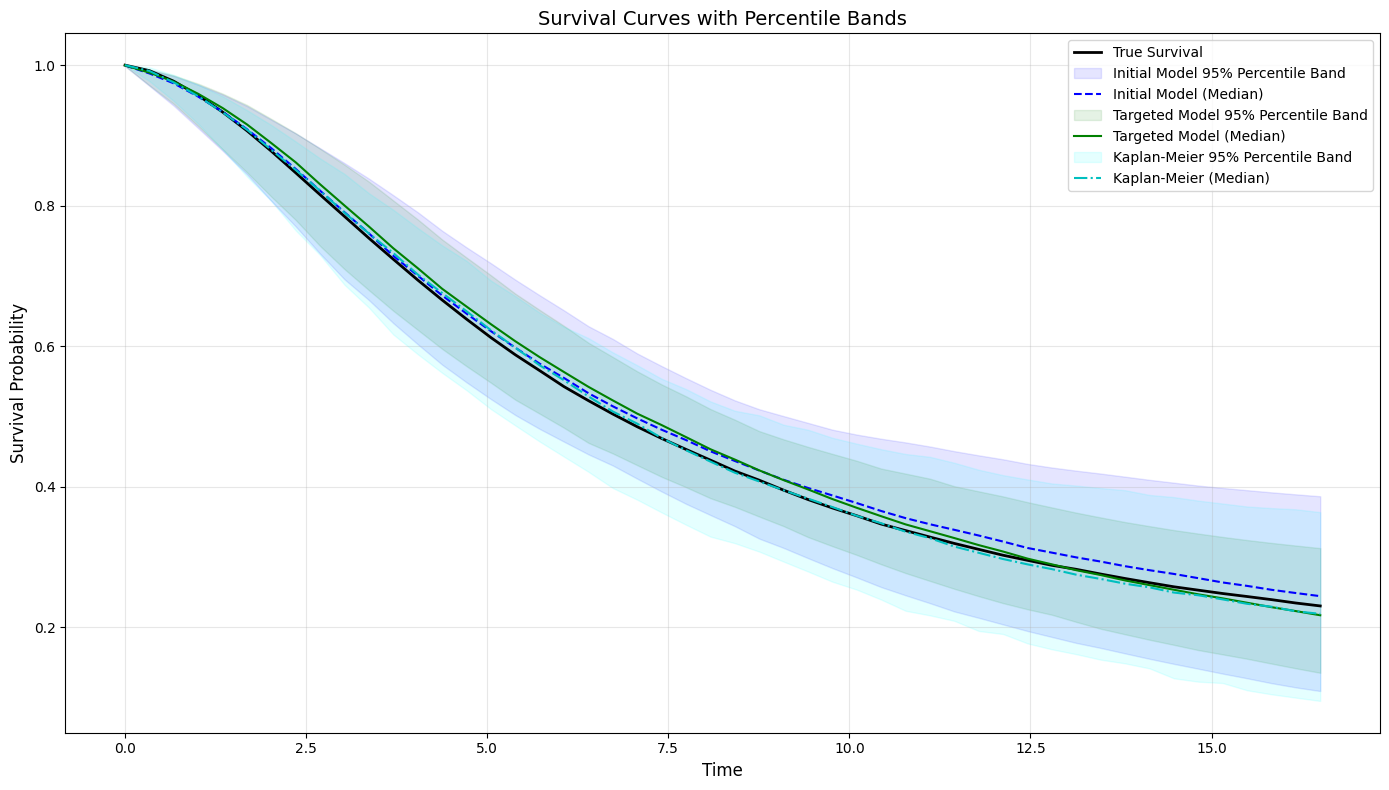

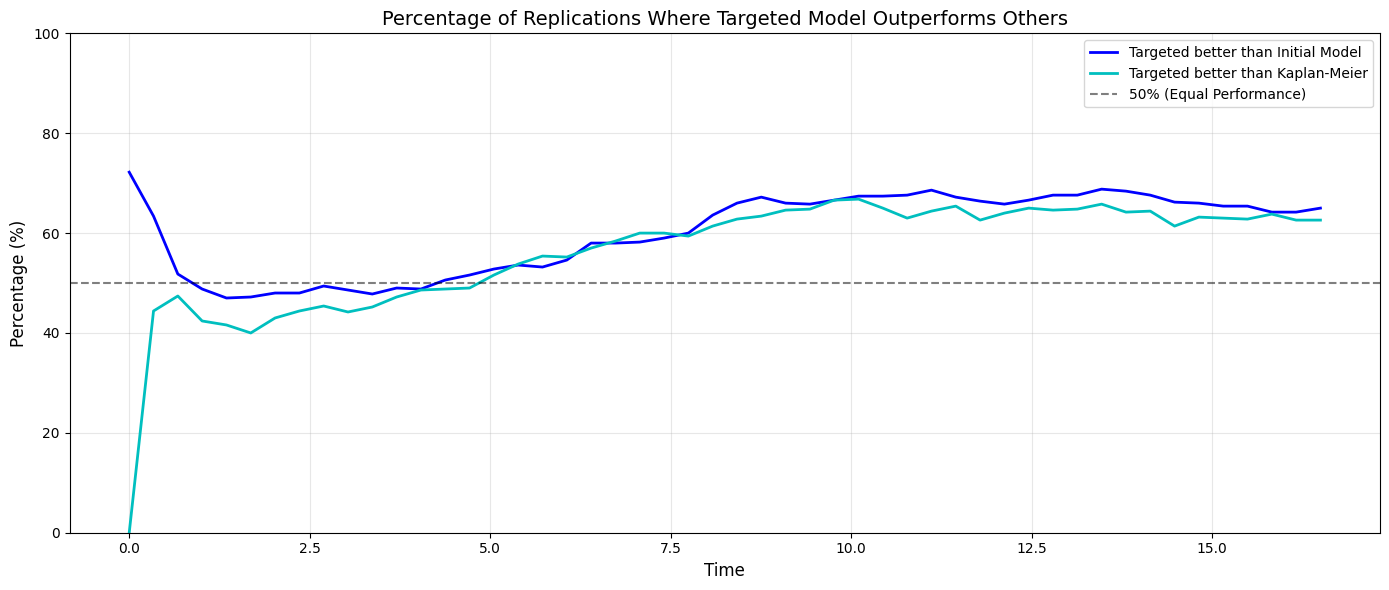

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats

# Load all replication data
results_dir = 'results'
all_reps_file = os.path.join(results_dir, 'all_replications_metrics.csv')
survival_curves_file = os.path.join(results_dir, 'average_survival_curves.csv')

if not os.path.exists(all_reps_file) or not os.path.exists(survival_curves_file):
    raise FileNotFoundError(f"Could not find required files in {results_dir}")

# Load average data to get time points
avg_data = pd.read_csv(survival_curves_file)
time_points = avg_data['time'].values

# Function to parse array strings from CSV
def parse_array_string(array_str):
    try:
        # Try first format with spaces
        arr = np.array([float(x) for x in array_str.strip('[]').split()])
        if len(arr) == 0:
            # Try alternate format with commas
            arr = np.array([float(x) for x in array_str.strip('[]').split(',')])
        return arr
    except:
        print(f"Error parsing array: {array_str[:30]}...")
        return np.array([])

# Load all replication data
reps_data = pd.read_csv(all_reps_file)
n_reps = len(reps_data)
print(f"Loaded data from {n_reps} replications")

# Collect all survival curves from each replication
initial_curves = []
targeted_curves = []
km_curves = []
true_curves = []

# Process each replication
for i, row in reps_data.iterrows():
    try:
        # Extract curves - handling both list formats
        true_curve = parse_array_string(row['true_survival'])
        initial_curve = parse_array_string(row['initial_survival'])
        targeted_curve = parse_array_string(row['targeted_survival'])
        km_curve = parse_array_string(row['km_survival'])
        
        # Only append if all parsing was successful and lengths match
        if len(true_curve) > 0 and len(true_curve) == len(time_points):
            true_curves.append(true_curve)
            initial_curves.append(initial_curve)
            targeted_curves.append(targeted_curve)
            km_curves.append(km_curve)
    except Exception as e:
        print(f"Error processing replication {i}: {e}")

# Convert to numpy arrays
true_curves = np.array(true_curves)
initial_curves = np.array(initial_curves)
targeted_curves = np.array(targeted_curves)
km_curves = np.array(km_curves)

print(f"Successfully parsed {len(true_curves)} replications")
print(f"Shape of survival curves: {true_curves.shape}")

# Calculate squared errors at each time point for each replication
initial_errors = (initial_curves - true_curves)**2
targeted_errors = (targeted_curves - true_curves)**2
km_errors = (km_curves - true_curves)**2

# 1. CONFIDENCE BANDS VISUALIZATION
# Calculate percentiles for all models at each time point
percentiles = [2.5, 25, 50, 75, 97.5]  # 5th, 25th, 50th (median), 75th, and 95th percentiles

initial_percentiles = np.percentile(initial_curves, percentiles, axis=0)
targeted_percentiles = np.percentile(targeted_curves, percentiles, axis=0)
km_percentiles = np.percentile(km_curves, percentiles, axis=0)
true_median = np.median(true_curves, axis=0)

# Plot confidence bands
plt.figure(figsize=(14, 8))

# True survival function
plt.plot(time_points, true_median, 'k-', linewidth=2, label='True Survival')

# Initial model with confidence bands
plt.fill_between(time_points, initial_percentiles[0], initial_percentiles[4], 
                 color='blue', alpha=0.1, label='Initial Model 95% Percentile Band')
plt.plot(time_points, initial_percentiles[2], 'b--', linewidth=1.5, label='Initial Model (Median)')

# Targeted model with confidence bands
plt.fill_between(time_points, targeted_percentiles[0], targeted_percentiles[4], 
                 color='green', alpha=0.1, label='Targeted Model 95% Percentile Band')
plt.plot(time_points, targeted_percentiles[2], 'g-', linewidth=1.5, label='Targeted Model (Median)')

# Kaplan-Meier with confidence bands
plt.fill_between(time_points, km_percentiles[0], km_percentiles[4], 
                 color='cyan', alpha=0.1, label='Kaplan-Meier 95% Percentile Band')
plt.plot(time_points, km_percentiles[2], 'c-.', linewidth=1.5, label='Kaplan-Meier (Median)')

# Customize the plot
plt.title('Survival Curves with Percentile Bands', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(True, alpha=0.3)

# Create a custom legend with fewer items
# handles, labels = plt.gca().get_legend_handles_labels()
# selected_handles = [handles[0]]  # True Survival
# for i in range(2, len(handles), 3):  # Take only the median lines for each method
#     selected_handles.append(handles[i])

# selected_labels = [labels[0]]
# for i in range(2, len(labels), 3):
#     selected_labels.append(labels[i])

# plt.legend(selected_handles, selected_labels, fontsize=10, loc='upper right')

# Create a custom legend with main items
handles, labels = plt.gca().get_legend_handles_labels()

# Select true survival, and for each model: its CI and median
selected_handles = [handles[0]]  # True Survival
for i in range(1, len(handles), 2):  # Take CI and median for each method
    if i < len(handles):
        selected_handles.append(handles[i])  # CI
    if i+1 < len(handles):
        selected_handles.append(handles[i+1])  # Median

selected_labels = [labels[0]]  # True Survival
for i in range(1, len(labels), 2):  # Take CI and median for each method
    if i < len(labels):
        selected_labels.append(labels[i])  # CI
    if i+1 < len(labels):
        selected_labels.append(labels[i+1])  # Median

plt.legend(selected_handles, selected_labels, fontsize=10, loc='upper right')


plt.tight_layout()

# Save the figure
output_path = os.path.join(results_dir, 'survival_curves_with_percentile_bands.png')
plt.savefig(output_path, dpi=300)
print(f"Confidence bands plot saved to {output_path}")

# 4. RELATIVE PERFORMANCE METRIC: TARGETED vs OTHERS
# Calculate the proportion of replications where targeted model outperforms others
better_than_initial = (targeted_errors < initial_errors).mean(axis=0) * 100
better_than_km = (targeted_errors < km_errors).mean(axis=0) * 100

plt.figure(figsize=(14, 6))
plt.plot(time_points, better_than_initial, 'b-', linewidth=2, 
         label='Targeted better than Initial Model')
plt.plot(time_points, better_than_km, 'c-', linewidth=2, 
         label='Targeted better than Kaplan-Meier')
plt.axhline(y=50, color='k', linestyle='--', alpha=0.5, 
            label='50% (Equal Performance)')
plt.title('Percentage of Replications Where Targeted Model Outperforms Others', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()

# Save the figure
perf_path = os.path.join(results_dir, 'targeted_performance_percentage.png')
plt.savefig(perf_path, dpi=300)
print(f"Performance comparison plot saved to {perf_path}")